In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


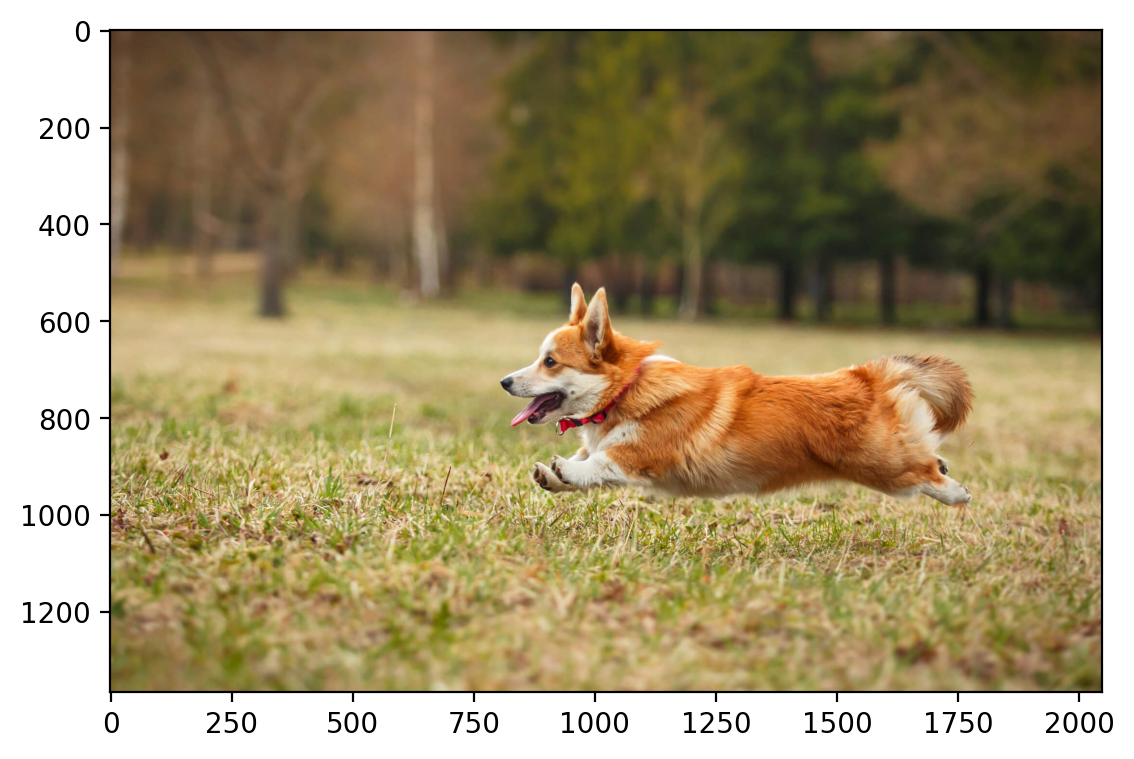

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape
crop.to(device)

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

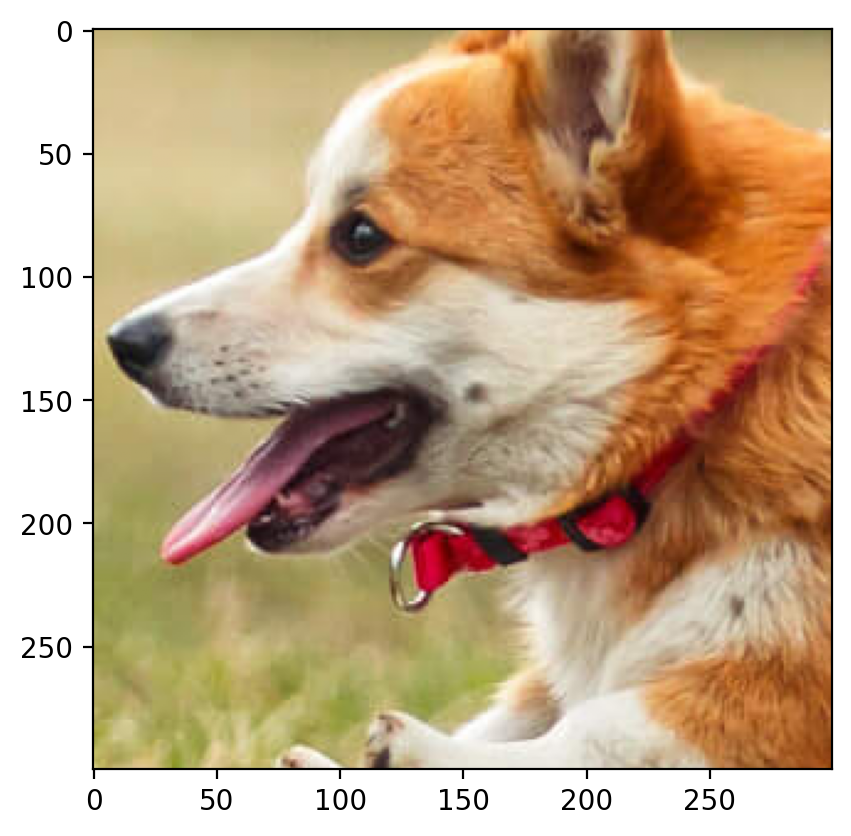

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
crop_ = rearrange(crop, 'c h w -> (h w) c').float()

In [ ]:
crop_.shape

torch.Size([90000, 3])

In [ ]:
def mask_image(img, prop):
    #img=img.cpu().numpy()
    img_copy = img.clone()
    mask = torch.rand((img.shape[0],1)) < prop
    mask.t()
    repeated_tensor = torch.cat([mask] * 3, dim=1)
    #repeated_tensor=mask.repeat(1,3)
    print(repeated_tensor.shape)
    img_copy[repeated_tensor] = float('nan')
    img_copy.to(device)
    return img_copy, repeated_tensor

In [ ]:
# maskedImage=mask_image(crop_,0.3)

In [ ]:
# maskedImage[0].shape

In [ ]:
# plt.imshow(maskedImage[0].reshape(300,300,3).cpu().numpy())

In [ ]:
# if maskedImage[0].device.type == 'cuda':
#     print("Tensor is on GPU")
# else:
#     print("Tensor is on CPU")

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
# print(maskedImage[0].cpu().numpy())

In [ ]:
# mask = ~torch.isnan(maskedImage[0])

In [ ]:
# mmMask=mask.cpu().numpy().reshape(270000,1)
# mmImage=maskedImage[0].cpu().numpy().reshape(270000,1)
# mmImage[mmMask==False]=np.random.uniform(0,1)

In [ ]:
# mmImage=torch.tensor(mmImage.reshape(90000,3),dtype=torch.float32).to(device)

In [ ]:
# mask = ~torch.isnan(maskedImage[0])
# print(mask.shape)
# masked_image=maskedImage[0][mask]
# masked_image=masked_image.reshape(63215,3)

In [ ]:
# X_rff = create_rff_features(mmImage, 37500, 0.008)

In [ ]:
# X_rff.shape

In [ ]:
# def train(net, lr, X, Y, epochs, verbose=True):
#     """
#     net: torch.nn.Module
#     lr: float
#     X: torch.Tensor of shape (num_samples, 2)
#     Y: torch.Tensor of shape (num_samples, 3)
#     """

#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         outputs = net(X)
#         loss = criterion(outputs, Y)
#         loss.backward()
#         optimizer.step()
#         if verbose and epoch % 100 == 0:
#             print(f"Epoch {epoch} loss: {loss.item():.6f}")
#     return loss.item()

In [ ]:
def train(net, lr, X, Y, epochs, batch_size=32, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    epochs: int
    batch_size: int, default=32
    verbose: bool, default=True
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    num_samples = X.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(num_batches):
            optimizer.zero_grad()
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_X = X[start_idx:end_idx]
            batch_Y = Y[start_idx:end_idx]
            outputs = net(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {running_loss / num_batches:.6f}")


In [ ]:
# net = LinearModel(X_rff.shape[1], 3)
# net.to(device)
# crop_=torch.tensor(crop_,dtype=torch.float32).to(device)
# train(net, 0.005, X_rff,crop_, 2500)

In [ ]:
Errors={'Masking precentage':[],'RMSE': [],'Peak SNR':[]}

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X,maskedImage,prop, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(300, 300, 3)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    ax2.imshow(maskedImage.reshape(300,300,3).cpu().numpy())
    ax2.set_title(f"Image  with {prop*100}% missing data")

    squared_error = torch.square(outputs.cpu() - original_img.cpu().permute(1,2,0))
    mse = torch.mean(squared_error)


    # Calculate the root mean squared error
    rmse = torch.sqrt(mse)

    # Calculate the peak signal value (assuming the vectors are in the range [0, 1])
    max_val = 1.0
    psnr = 10 * torch.log10(max_val / rmse)
    Errors["Masking precentage"].append(prop)
    Errors["RMSE"].append(rmse)
    Errors["Peak SNR"].append(psnr)
    print(f"masking: {prop} , RMSE: {rmse}, PSNR: {psnr} \n")

# Calculate the PSNR
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
#plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image")

torch.Size([90000, 3])
Epoch 0 loss: 0.037292
Epoch 100 loss: 0.006618
Epoch 200 loss: 0.006482
Epoch 300 loss: 0.006607
Epoch 400 loss: 0.006513
Epoch 500 loss: 0.006442
Epoch 600 loss: 0.006492
Epoch 700 loss: 0.006594
Epoch 800 loss: 0.006616
Epoch 900 loss: 0.006596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.1 , RMSE: 0.08130888234467955, PSNR: 10.898620086178678 

torch.Size([90000, 3])
Epoch 0 loss: 0.036414
Epoch 100 loss: 0.009071
Epoch 200 loss: 0.009003
Epoch 300 loss: 0.008983
Epoch 400 loss: 0.008974
Epoch 500 loss: 0.008970
Epoch 600 loss: 0.008967
Epoch 700 loss: 0.008966
Epoch 800 loss: 0.008965
Epoch 900 loss: 0.008964


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.2 , RMSE: 0.11470628888011884, PSNR: 9.40412770842755 

torch.Size([90000, 3])
Epoch 0 loss: 0.037653
Epoch 100 loss: 0.013081
Epoch 200 loss: 0.012947
Epoch 300 loss: 0.012899
Epoch 400 loss: 0.012875
Epoch 500 loss: 0.012862
Epoch 600 loss: 0.012854
Epoch 700 loss: 0.012848
Epoch 800 loss: 0.012844
Epoch 900 loss: 0.012842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.3 , RMSE: 0.13989382309082798, PSNR: 8.542014610392075 

torch.Size([90000, 3])
Epoch 0 loss: 0.037948
Epoch 100 loss: 0.015838
Epoch 200 loss: 0.015695
Epoch 300 loss: 0.015630
Epoch 400 loss: 0.015589
Epoch 500 loss: 0.015559
Epoch 600 loss: 0.015535
Epoch 700 loss: 0.015515
Epoch 800 loss: 0.015498
Epoch 900 loss: 0.015484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.4 , RMSE: 0.16691676552839838, PSNR: 7.775000395293347 

torch.Size([90000, 3])
Epoch 0 loss: 0.038973
Epoch 100 loss: 0.019341
Epoch 200 loss: 0.019208
Epoch 300 loss: 0.019154
Epoch 400 loss: 0.019125
Epoch 500 loss: 0.019106
Epoch 600 loss: 0.019094
Epoch 700 loss: 0.019085
Epoch 800 loss: 0.019078
Epoch 900 loss: 0.019072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.5 , RMSE: 0.16364897853644975, PSNR: 7.860867011251051 

torch.Size([90000, 3])
Epoch 0 loss: 0.039284
Epoch 100 loss: 0.022374
Epoch 200 loss: 0.022277
Epoch 300 loss: 0.022239
Epoch 400 loss: 0.022217
Epoch 500 loss: 0.022203
Epoch 600 loss: 0.022193
Epoch 700 loss: 0.022186
Epoch 800 loss: 0.022180
Epoch 900 loss: 0.022176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.6 , RMSE: 0.18623353814748475, PSNR: 7.2994210573497575 

torch.Size([90000, 3])
Epoch 0 loss: 0.040416
Epoch 100 loss: 0.025923
Epoch 200 loss: 0.025854
Epoch 300 loss: 0.025828
Epoch 400 loss: 0.025814
Epoch 500 loss: 0.025805
Epoch 600 loss: 0.025799
Epoch 700 loss: 0.025794
Epoch 800 loss: 0.025790
Epoch 900 loss: 0.025787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.7 , RMSE: 0.20409762459789416, PSNR: 6.9016204981616935 

torch.Size([90000, 3])
Epoch 0 loss: 0.041094
Epoch 100 loss: 0.029340
Epoch 200 loss: 0.029286
Epoch 300 loss: 0.029266
Epoch 400 loss: 0.029256
Epoch 500 loss: 0.029249
Epoch 600 loss: 0.029245
Epoch 700 loss: 0.029241
Epoch 800 loss: 0.029239
Epoch 900 loss: 0.029236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.8 , RMSE: 0.20979893171257333, PSNR: 6.781967275462536 

torch.Size([90000, 3])
Epoch 0 loss: 0.041589
Epoch 100 loss: 0.032904
Epoch 200 loss: 0.032882
Epoch 300 loss: 0.032876
Epoch 400 loss: 0.032873
Epoch 500 loss: 0.032872
Epoch 600 loss: 0.032871
Epoch 700 loss: 0.032870
Epoch 800 loss: 0.032869
Epoch 900 loss: 0.032869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


masking: 0.9 , RMSE: 0.22440202310023866, PSNR: 6.4897323200897175 

ErrorDF:     Masking precentage                                 RMSE  \
0                 0.1  tensor(0.0813, dtype=torch.float64)   
1                 0.2  tensor(0.1147, dtype=torch.float64)   
2                 0.3  tensor(0.1399, dtype=torch.float64)   
3                 0.4  tensor(0.1669, dtype=torch.float64)   
4                 0.5  tensor(0.1636, dtype=torch.float64)   
5                 0.6  tensor(0.1862, dtype=torch.float64)   
6                 0.7  tensor(0.2041, dtype=torch.float64)   
7                 0.8  tensor(0.2098, dtype=torch.float64)   
8                 0.9  tensor(0.2244, dtype=torch.float64)   

                               Peak SNR  
0  tensor(10.8986, dtype=torch.float64)  
1   tensor(9.4041, dtype=torch.float64)  
2   tensor(8.5420, dtype=torch.float64)  
3   tensor(7.7750, dtype=torch.float64)  
4   tensor(7.8609, dtype=torch.float64)  
5   tensor(7.2994, dtype=torch.float64)  
6   te

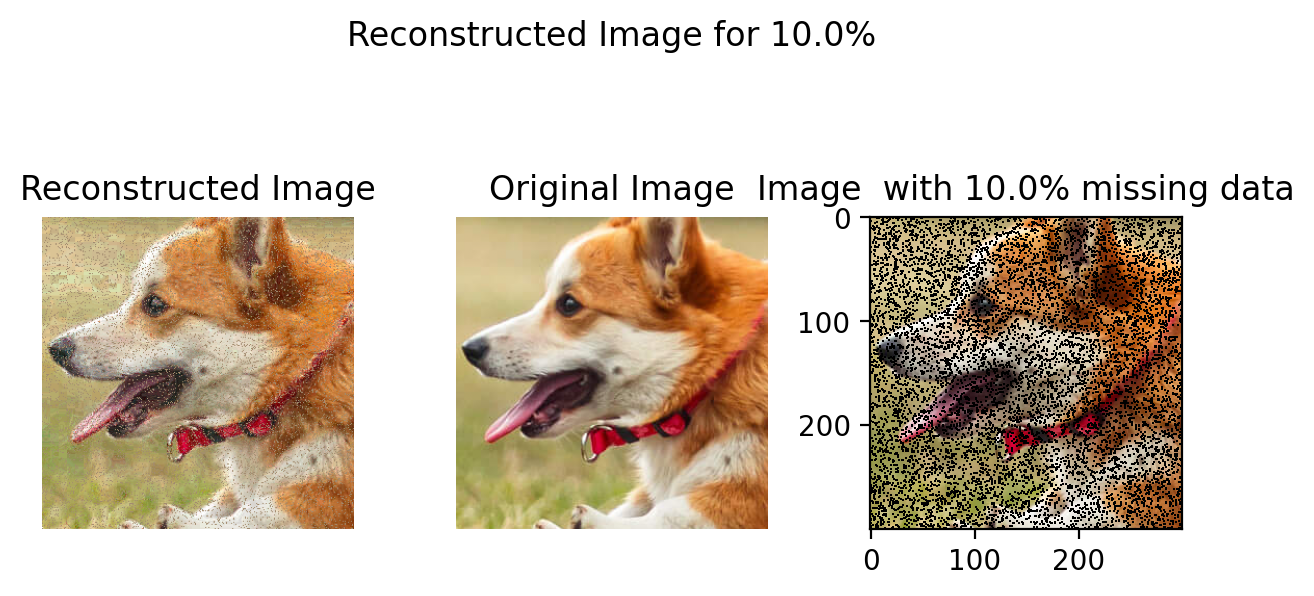

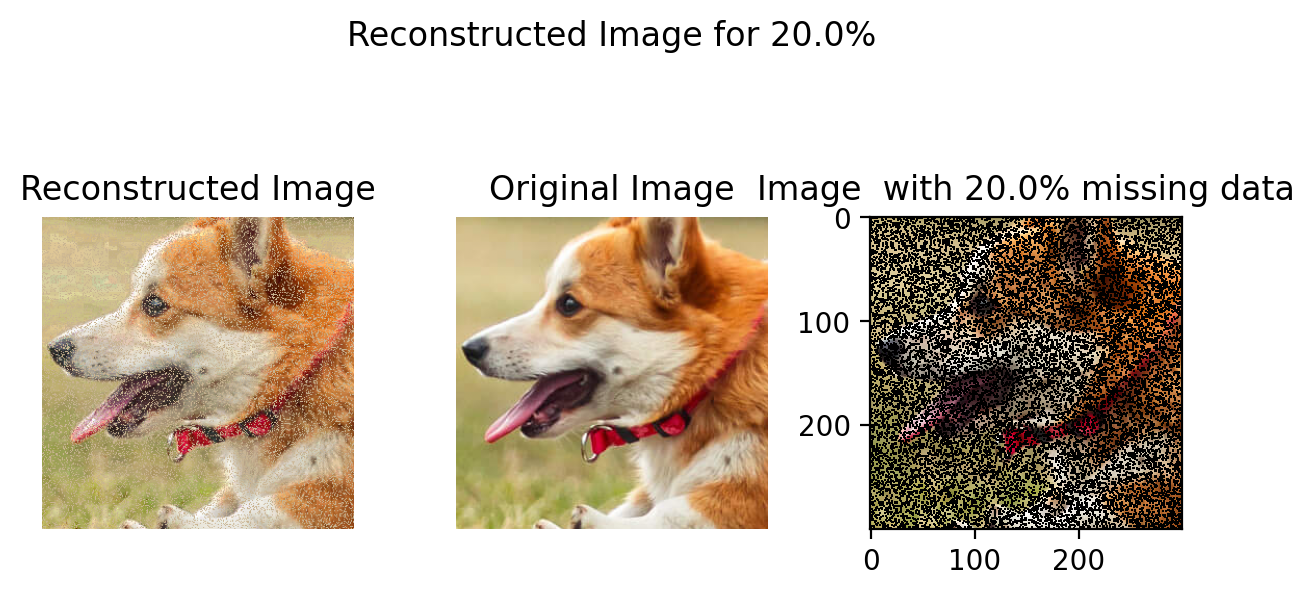

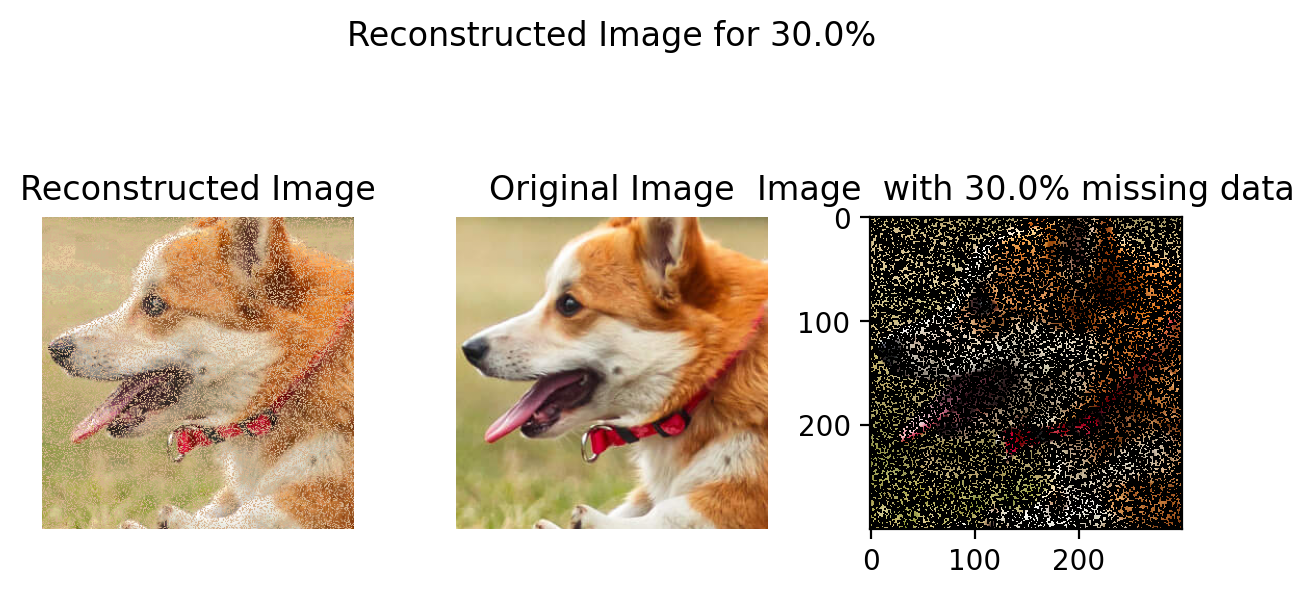

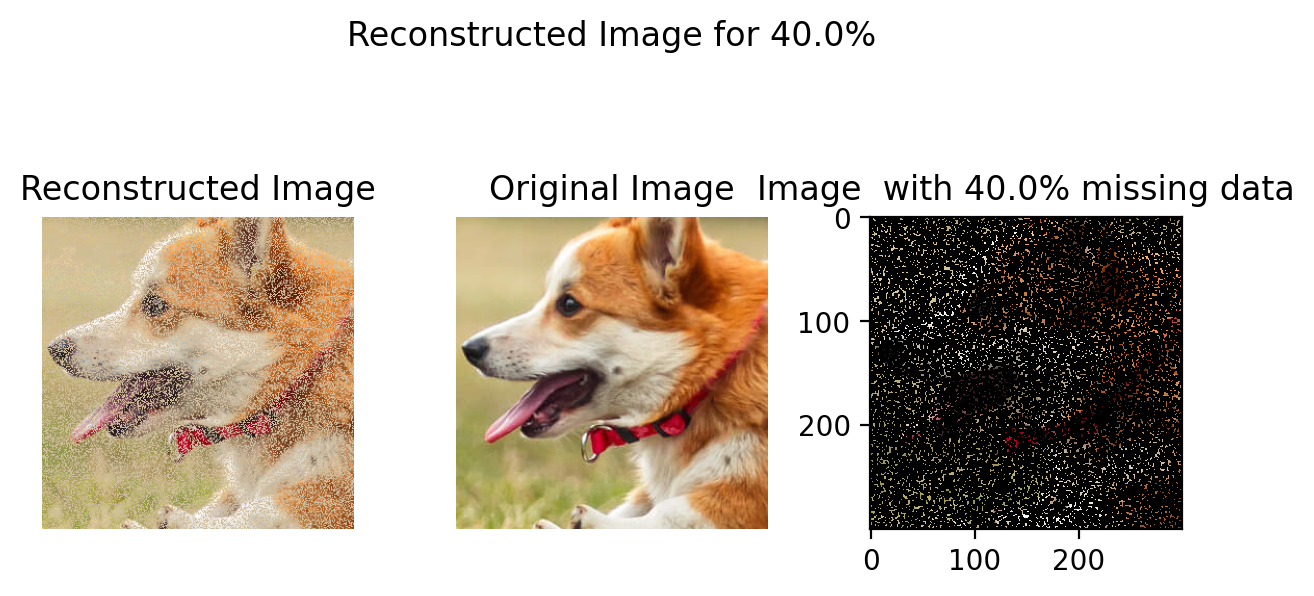

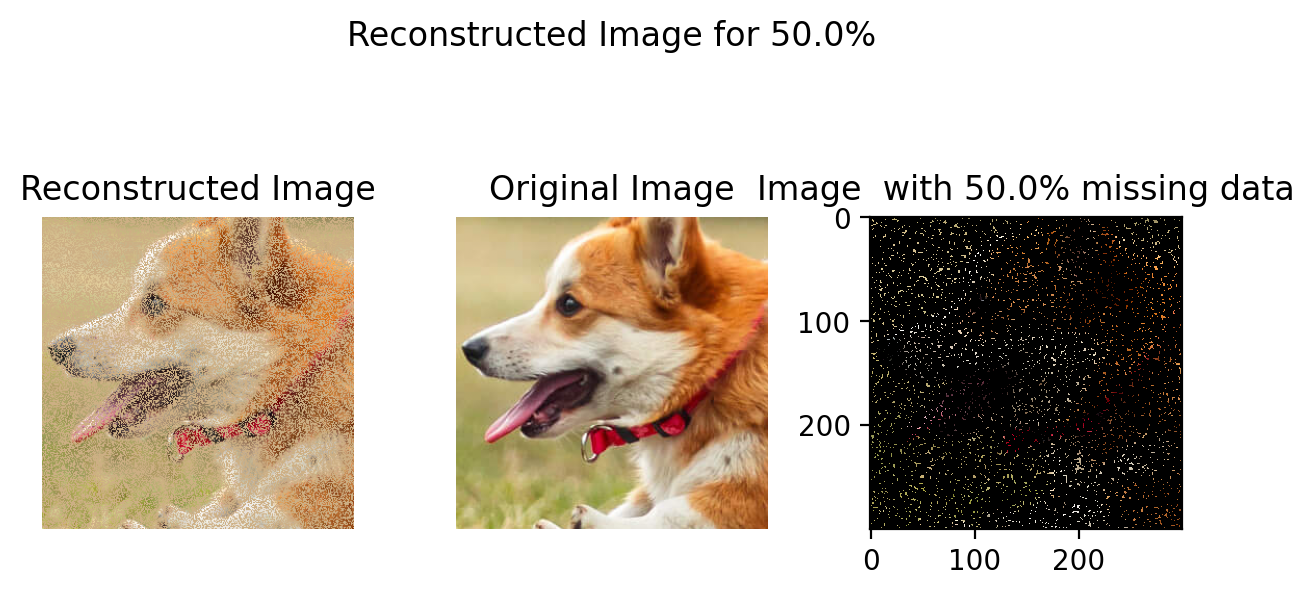

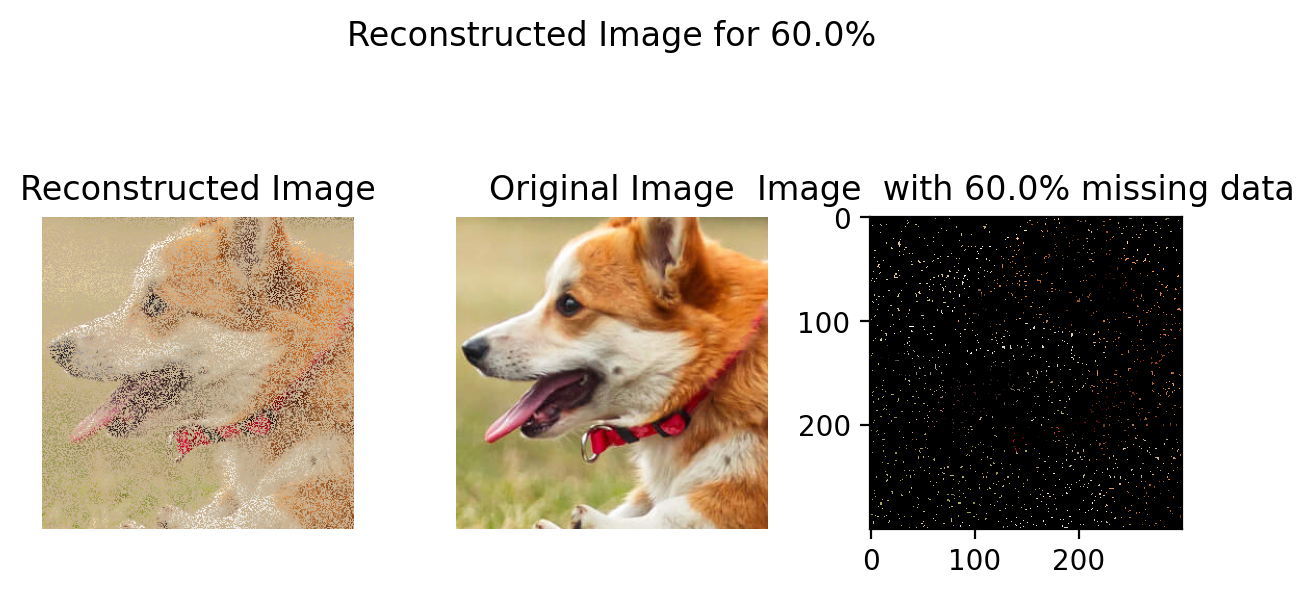

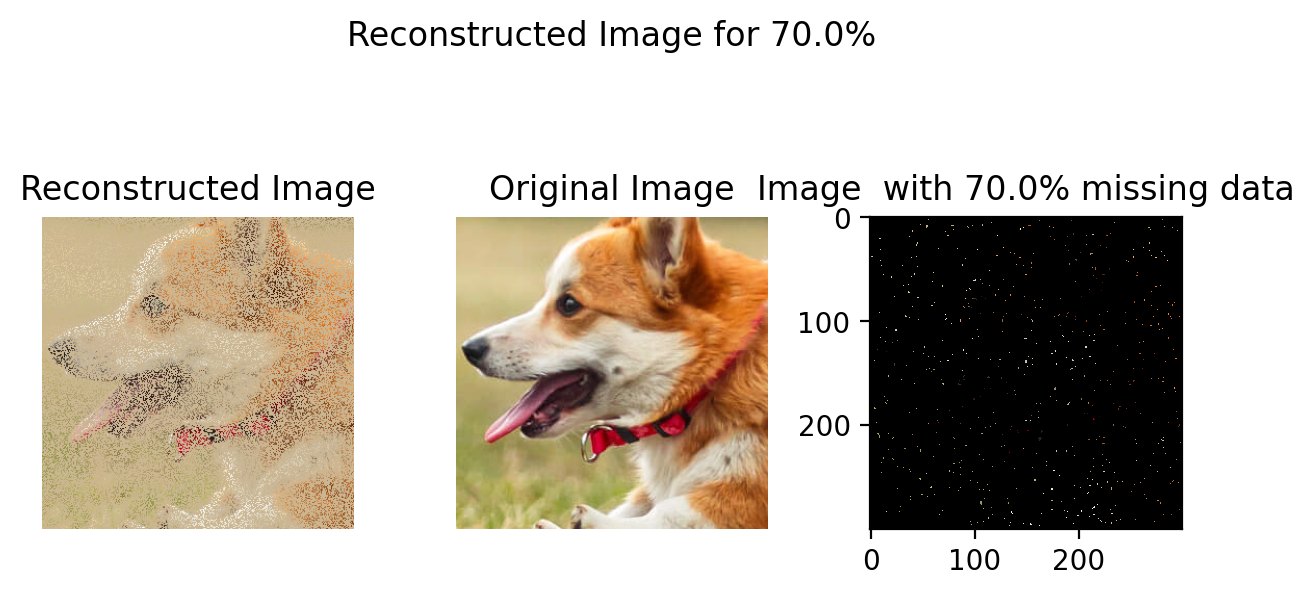

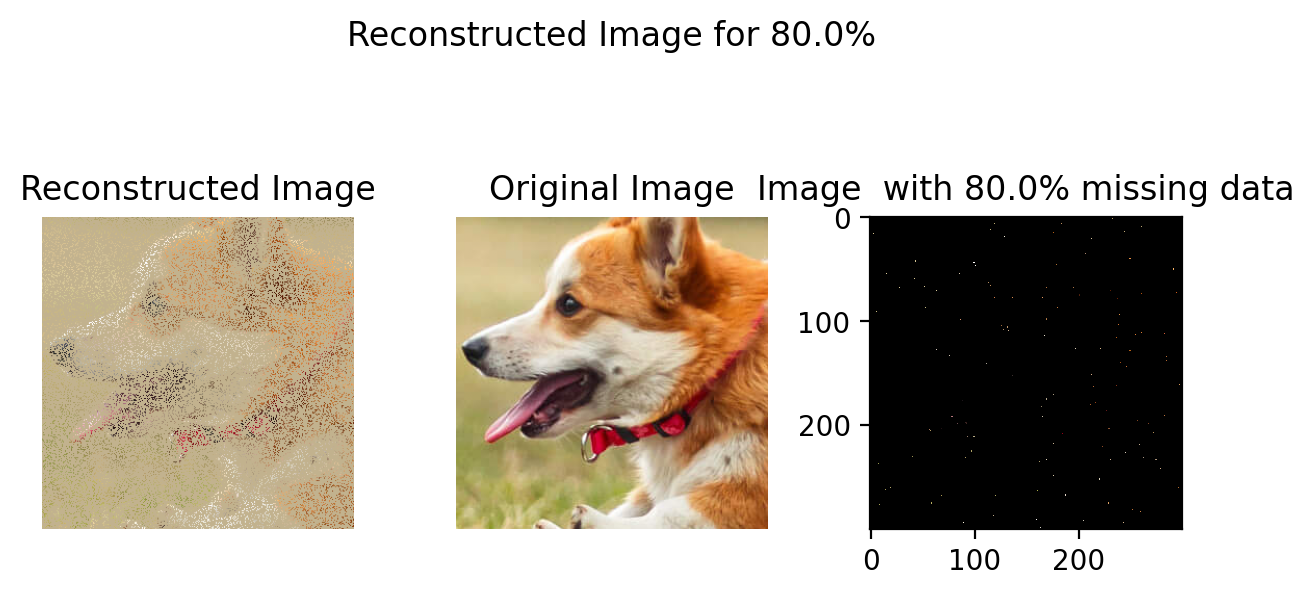

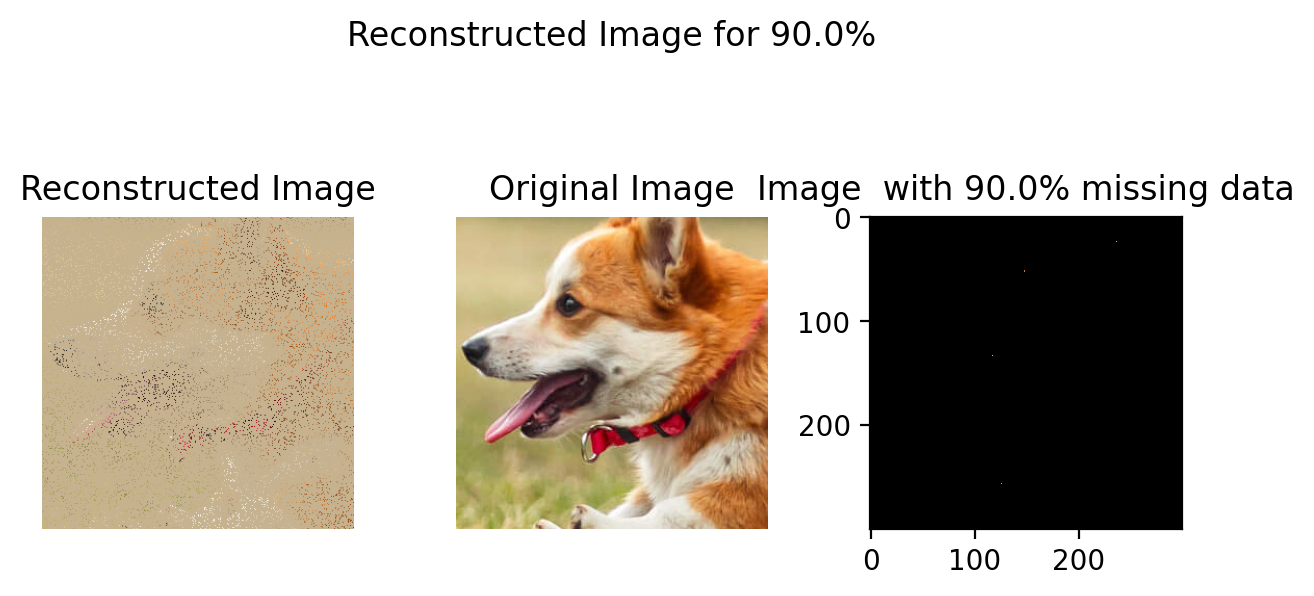

In [ ]:
Mask_array=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
crop_=torch.tensor(crop_,dtype=torch.float32).to(device)
for prop in Mask_array:
    maskedImage=mask_image(crop_,prop)
    # plt.title(f"Image  with {prop*100}% missing data")
    # plt.imshow(maskedImage[0].reshape(300,300,3).cpu().numpy())
    mask = ~torch.isnan(maskedImage[0])
    mmMask=mask.cpu().numpy().reshape(270000,1)
    mmImage=maskedImage[0].cpu().numpy().reshape(270000,1)
    mmImage[mmMask==False]=np.random.uniform(0,1)
    mmImage=torch.tensor(mmImage.reshape(90000,3),dtype=torch.float32).to(device)
    X_rff = create_rff_features(mmImage, 10000, 0.008)
    net = LinearModel(X_rff.shape[1], 3)
    net.to(device)
    train(net, 0.005, X_rff,crop_, 1000,100,True)
    plot_reconstructed_and_original_image(crop, net, X_rff,maskedImage[0],prop, title=f"Reconstructed Image for {prop*100}%")
    del X_rff

ErrorDF=pd.DataFrame(Errors)
ErrorDF.reset_index(drop=True, inplace=True)

print("ErrorDF: ",ErrorDF)




As we increase the masking percentage, the actual data(pixels in RGB) used for training would decrease.
Due to that the model contains high bias and low variace towards training points.
Hence image are not properly constructed for high masking percentage